<a href="https://colab.research.google.com/github/asmanadeem29/Counter/blob/main/lung_seg_unetr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
import os
import zipfile
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the dataset folder in Google Drive
dataset_folder_path = '/content/drive/MyDrive/ChestXray'

In [ ]:
# Seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
#parameters defined
batch_size = 10
lr = 1e-4
epochs = 5
#height = 256
#width = 256

In [ ]:
# Define paths
dataset_path = '/content/drive/MyDrive/ChestXray'
files_dir = '/content/drive/MyDrive/ChestXray/lungseg_Files'
images_dir = os.path.join(files_dir, 'images')
model_file = os.path.join(files_dir, 'unetr-train-image.keras')
log_file = os.path.join(files_dir, 'logunetr-train-image.csv')

# Create the 'Files' directory if it doesn't exist
if not os.path.exists(files_dir):
    os.makedirs(files_dir)

# Create the 'images' directory within 'Files' if it doesn't exist
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

print("Train Images Directory:", dataset_path)


Train Images Directory: /content/drive/MyDrive/ChestXray


In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

# Define a multi-layer perceptron block
def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

# Define a transformer encoder block
def transformer_encoder(x, cf):
    skip_1 = x
    x_before_norm = x  # Save the input tensor before normalization
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x_before_mlp = x  # Save the tensor before MLP
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x_before_norm, x_before_mlp, x

# Define a convolutional block
def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)  # Convolutional layer
    x = L.BatchNormalization()(x)  # Batch normalization
    x = L.ReLU()(x)  # ReLU activation
    return x

# Define a deconvolutional block
def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)  # Deconvolutional layer
    return x

# Build the UNETR-2D model
def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"] * cf["patch_size"] * cf["num_channels"])
    inputs = L.Input(input_shape)  # Input layer
    print(f"Input shape: {inputs.shape}")


    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs)  # Patch embedding
    print(f"Patch embedding shape: {patch_embed.shape}")

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)  # Generate positions
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)  # Positional embedding
    x = patch_embed + pos_embed  # Combine patch and positional embeddings
    #print(pos_embed.shape)
    #print(x.shape)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"] + 1, 1):
        x_before_norm, x_before_mlp, x = transformer_encoder(x, cf)  # Apply transformer encoder
        print(f"Input shape before LayerNormalization in encoder layer {i}: {x_before_norm.shape}")
        print(f"Input shape before MLP in encoder layer {i}: {x_before_mlp.shape}")
        print(f"Intermediate shape after encoder layer {i}: {x.shape}")

        if i in skip_connection_index:
            skip_connections.append(x)

    #print(x.shape)

    """CNN Decoder"""
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)
    print(z3.shape, z6.shape, z9.shape, z12.shape)

    ## Decoder 1
    x = deconv_block(z12, 512)  # Deconvolutional block with 512 filters
    print(f"Shape after Decoder 1: {x.shape}")

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)  # Convolutional block with 512 filters
    #print(x.shape, s.shape)
    x = L.Concatenate()([x, s])
    #print(x.shape)

    # Yellow block
    x = conv_block(x, 512)  # Convolutional block with 512 filters
    x = conv_block(x, 512)  # Convolutional block with 512 filters
    print(f"Shape after decoder 1: {x.shape}")

    ## Decoder 2
    x = deconv_block(x, 256)  # Deconvolutional block with 256 filters
    print(f"Shape after Decoder 2: {x.shape}")

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)  # Convolutional block with 256 filters
    s = deconv_block(s, 256)  # Deconvolutional block with 256 filters
    s = conv_block(s, 256)  # Convolutional block with 256 filters
    #print(x.shape, s.shape)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)  # Convolutional block with 256 filters
    x = conv_block(x, 256)  # Convolutional block with 256 filters

    ## Decoder 3
    x = deconv_block(x, 128)  # Deconvolutional block with 128 filters
    print(f"Shape after Decoder 3: {x.shape}")

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)  # Convolutional block with 128 filters
    s = deconv_block(s, 128)  # Deconvolutional block with 128 filters
    s = conv_block(s, 128)  # Convolutional block with 128 filters
    s = deconv_block(s, 128)  # Deconvolutional block with 128 filters
    s = conv_block(s, 128)  # Convolutional block with 128 filters

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)  # Convolutional block with 128 filters
    x = conv_block(x, 128)  # Convolutional block with 128 filters

    ## Decoder 4
    x = deconv_block(x, 64)  # Deconvolutional block with 64 filters
    print(f"Shape after Decoder 4: {x.shape}")

    s = conv_block(z0, 64)  # Convolutional block with 64 filters
    s = conv_block(s, 64)  # Convolutional block with 64 filters

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)  # Convolutional block with 64 filters
    x = conv_block(x, 64)  # Convolutional block with 64 filters

    """ Output"""
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)  # Output layer
    print(f"Output shape: {outputs.shape}")

    return Model(inputs, outputs, name="UNETR_2D")


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 256
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_channels"] = 1
    config["image_size"] = 256
    config["patch_size"] = 16
    config["num_patches"] = int(config["image_size"] / config["patch_size"]) ** 2


    model = build_unetr_2d(config)
    model.summary()

Input shape: (None, 256, 256)
Patch embedding shape: (None, 256, 256)
Input shape before LayerNormalization in encoder layer 1: (None, 256, 256)
Input shape before MLP in encoder layer 1: (None, 256, 256)
Intermediate shape after encoder layer 1: (None, 256, 256)
Input shape before LayerNormalization in encoder layer 2: (None, 256, 256)
Input shape before MLP in encoder layer 2: (None, 256, 256)
Intermediate shape after encoder layer 2: (None, 256, 256)
Input shape before LayerNormalization in encoder layer 3: (None, 256, 256)
Input shape before MLP in encoder layer 3: (None, 256, 256)
Intermediate shape after encoder layer 3: (None, 256, 256)
Input shape before LayerNormalization in encoder layer 4: (None, 256, 256)
Input shape before MLP in encoder layer 4: (None, 256, 256)
Intermediate shape after encoder layer 4: (None, 256, 256)
Input shape before LayerNormalization in encoder layer 5: (None, 256, 256)
Input shape before MLP in encoder layer 5: (None, 256, 256)
Intermediate shape 

Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_50 (Dense)          │ (None, 256, 256)       │         65,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_50 (Add)              │ (None, 256, 256)       │              0 │ dense_50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_48    │ (None, 256, 256)       │            512 │ add_50[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_24   │ (None, 256, 256)       │      3,155,200 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_51 (Add)              │ (None, 256, 256)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_50[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_49    │ (None, 256, 256)       │            512 │ add_51[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_51 (Dense)          │ (None, 256, 3072)      │        789,504 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_73 (Dropout)      │ (None, 256, 3072)      │              0 │ dense_51[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_52 (Dense)          │ (None, 256, 256)       │        786,688 │ dropout_73[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_74 (Dropout)      │ (None, 256, 256)       │              0 │ dense_52[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_52 (Add)              │ (None, 256, 256)       │              0 │ dropout_74[0][0],      │
│                           │                        │                │ add_51[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_50    │ (None, 256, 256)       │            512 │ add_52[0][0]           │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_25   │ (None, 256, 256)       │      3,155,200 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_53 (Add)              │ (None, 256, 256)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_52[0][0]           │
├──────────────────────

 Total params: 72,816,705 (277.77 MB)

 Trainable params: 72,809,793 (277.75 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [ ]:
# Function to create directories
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

create_dir(files_dir)

In [ ]:
def load_data(path):
    train_x = sorted(glob(os.path.join(path, "train", "image", "*")))
    train_y = sorted(glob(os.path.join(path, "train", "mask", "*")))
    valid_x = sorted(glob(os.path.join(path, "val", "image", "*")))
    valid_y = sorted(glob(os.path.join(path, "val", "mask", "*")))


    return (train_x, train_y), (valid_x, valid_y)


# Example usage
dataset_path = '/content/drive/MyDrive/ChestXray'
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)

print("Number of Train Images:", len(train_x))
print("Number of Train Masks:", len(train_y))
print("Number of Train Images:", len(valid_x))
print("Number of Train Masks:", len(valid_y))

Number of Train Images: 16932
Number of Train Masks: 16932
Number of Train Images: 2117
Number of Train Masks: 2117


In [ ]:
def read_and_resize_image(path, target_size=(256, 256)):
    path = path.decode()  # Assuming path is a byte string, decode it to a regular string
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

    # Resize the image to the target size
    x = cv2.resize(x, target_size)

    # Normalize pixel values to the range [0, 1]
    x = x / 255.0

    return x


def read_and_resize_masks(path, target_size=(256, 256)):
    path = path.decode()  # Assuming path is a byte string, decode it to a regular string
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read the mask in grayscale

    # Resize the mask to the target size
    x = cv2.resize(x, target_size)

    # Normalize pixel values to the range [0, 1]
    x = x / 255.0

    return x


In [ ]:
# TensorFlow parse function for dataset
def tf_parse(x, y):
    def _parse(x, y):
        x = read_and_resize_image(x)
        y = read_and_resize_masks(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256])
    y.set_shape([256, 256])
    return x, y


In [ ]:
# TensorFlow dataset creation function
def tf_dataset(x, y, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Load training and validation data
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 16932 - 16932
Valid: 2117 - 2117


In [ ]:
# Compile the model
opt = tf.keras.optimizers.Adam(lr)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Create TensorFlow datasets
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)


In [ ]:
# Define callbacks
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/5
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8796 - loss: 0.2010
Epoch 1: val_loss improved from inf to 0.09923, saving model to /content/drive/MyDrive/ChestXray/lungseg_Files/unetr-train-image.keras
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 3122s 2s/step - accuracy: 0.8796 - loss: 0.2009 - val_accuracy: 0.9140 - val_loss: 0.0992 - learning_rate: 1.0000e-04
Epoch 2/5
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9280 - loss: 0.0601
Epoch 2: val_loss improved from 0.09923 to 0.08418, saving model to /content/drive/MyDrive/ChestXray/lungseg_Files/unetr-train-image.keras
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 690s 407ms/step - accuracy: 0.9280 - loss: 0.0602 - val_accuracy: 0.9172 - val_loss: 0.0842 - learning_rate: 1.0000e-04
Epoch 3/5
1694/1694 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9305 - loss: 0.0481
Epoch 3: val_loss improved from 0.08418 to 0.07539, saving model to /content/drive/MyDrive/ChestXray/lungseg_Files/unetr-train-image.keras
1694/1694 ━━━━━━━━━━━━━

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


<function matplotlib.pyplot.show(close=None, block=None)>

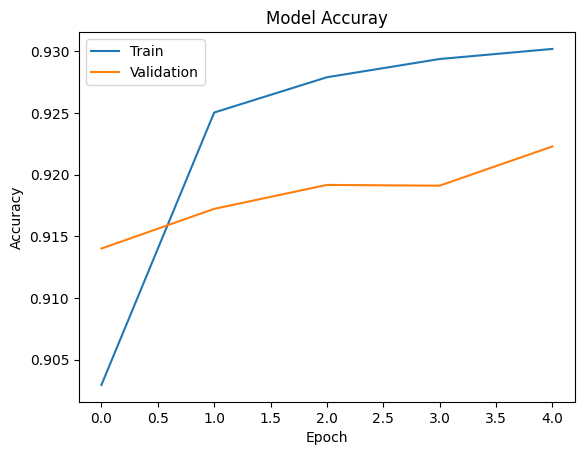

In [ ]:
print(history.history.keys())
#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuray')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left' )
plt.show

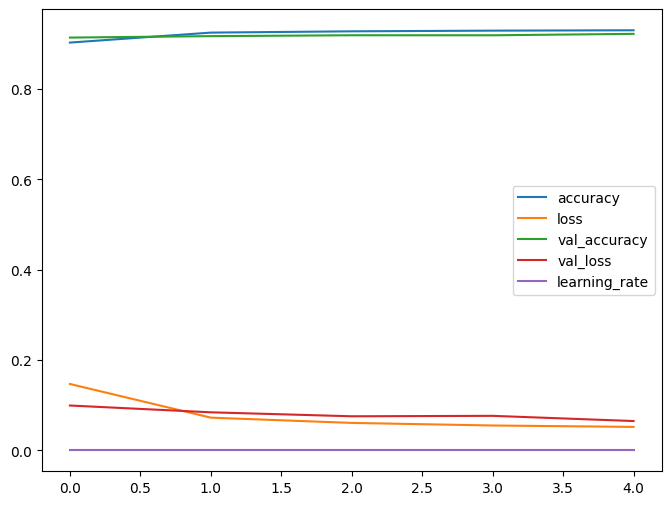

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.show()

In [ ]:
import os

# Define the directory path where you want to save the model
save_directory = "/content/drive/MyDrive/ChestXray"
# Define the model name with the .h5 extension
model_name = "UNETR_lung_seg.h5"
# Combine the directory path and model name
full_path = os.path.join(save_directory, model_name)

# Save the model to the specified path
model.save(full_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


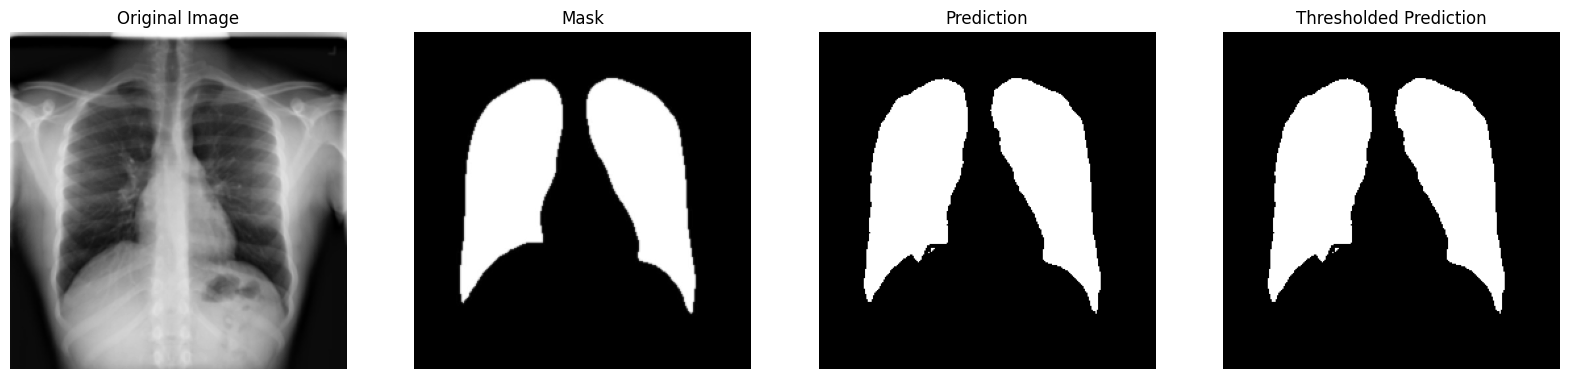

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the image
image_path = '/content/drive/MyDrive/ChestXray/test/image/cxrimage_16934.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Load the mask (assuming the mask is in the same directory with '_mask' suffix)
mask_path = "/content/drive/MyDrive/ChestXray/test/mask/cxrmask_16934.jpeg"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Resize the image and mask to the desired size (256x256)
resized_image = cv2.resize(image, (256, 256))
resized_mask = cv2.resize(mask, (256, 256))

# Normalize the image
input_image = resized_image / 255.0  # Normalize to [0, 1]

# Add batch dimension and channel dimension
input_image = np.expand_dims(input_image, axis=0)  # Shape: (1, 256, 256, 1)

# Assuming 'model' is defined elsewhere in your code and is already loaded and compiled
# Replace 'model' with your actual model instance

# Predict the segmentation on the resized image
segmented_image = model.predict(input_image)

# Post-process the segmented image
segmented_image = np.squeeze(segmented_image, axis=0)  # Remove batch dimension
segmented_image = (segmented_image > 0.5).astype(np.uint8)  # Threshold prediction

# Create a plot with the original image, mask, prediction, and thresholded prediction
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Display the original image
axs[0].imshow(resized_image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

# Display the mask
axs[1].imshow(resized_mask, cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

# Display the prediction
axs[2].imshow(segmented_image, cmap='gray')
axs[2].set_title('Prediction')
axs[2].axis('off')

# Display the thresholded prediction
thresholded_prediction = (segmented_image > 0.5).astype(np.uint8) * 255
axs[3].imshow(thresholded_prediction, cmap='gray')
axs[3].set_title('Thresholded Prediction')
axs[3].axis('off')

plt.show()


In [ ]:
import os
from glob import glob
import cv2
import numpy as np
from keras.models import load_model
from tqdm import tqdm

def load_test_data(path):
    test_x = sorted(glob(os.path.join(path, "test", "image", "*")))
    test_y = sorted(glob(os.path.join(path, "test", "mask", "*")))

    # Ensure equal lengths for test data
    min_length_test = min(len(test_x), len(test_y))
    test_x = test_x[:min_length_test]
    test_y = test_y[:min_length_test]

    return test_x, test_y

def preprocess_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)
    image = image.astype('float32') / 255.0  # normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)   # add channel dimension
    return image

def preprocess_mask(mask_path, target_size=(256, 256)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, target_size)
    mask = mask.astype('float32') / 255.0  # normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)   # add channel dimension
    return mask

def calculate_accuracy(true_masks, pred_masks):
    true_masks = true_masks.astype('bool')
    pred_masks = pred_masks.astype('bool')
    intersection = np.logical_and(true_masks, pred_masks)
    union = np.logical_or(true_masks, pred_masks)
    iou_score = np.sum(intersection) / np.sum(union)  # Intersection over Union
    return iou_score

# Example usage
dataset_path = '/content/drive/MyDrive/ChestXray'
model_path = '/content/drive/MyDrive/ChestXray/UNETR_lung_seg.h5'

# Load the saved model
model = load_model(model_path)

# Load test data
test_x, test_y = load_test_data(dataset_path)

print("Number of Test Images:", len(test_x))
print("Number of Test Masks:", len(test_y))

# Preprocess test data
test_images = [preprocess_image(img_path) for img_path in test_x]
test_masks = [preprocess_mask(mask_path) for mask_path in test_y]

test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Predict masks for test images
predicted_masks = model.predict(test_images)

# Binarize predicted masks (0 or 1)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

# Calculate accuracy
iou_scores = []
for true_mask, pred_mask in zip(test_masks, predicted_masks):
    iou = calculate_accuracy(true_mask, pred_mask)
    iou_scores.append(iou)

mean_iou = np.mean(iou_scores)
print(f"Test Accuracy (Mean IoU): {mean_iou}")


Number of Test Images: 2116
Number of Test Masks: 2116
67/67 [==============================] - 106s 1s/step
Test Accuracy (Mean IoU): 8.442015537789173e-06
